In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    accuracy_score,
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# --- Bước 1: Tải và Chuẩn bị Dữ liệu ---
print("--- Bước 1: Tải và Chuẩn bị Dữ liệu ---")
try:
    df = pd.read_csv('ngan_hang_hr_data (2).csv')
    print(f"Tải thành công {len(df)} dòng dữ liệu.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn '{df}'. Vui lòng kiểm tra lại.")
    exit()

--- Bước 1: Tải và Chuẩn bị Dữ liệu ---
Tải thành công 10000 dòng dữ liệu.


In [3]:
# --- Bước 2: Tiền xử lý & Khử nhiễu Cơ bản ---
print("\n--- Bước 2: Tiền xử lý & Khử nhiễu Cơ bản ---")

# Loại bỏ các cột định danh/cardinality cao không có giá trị dự đoán
# Đây là bước khử "rác" quan trọng nhất ban đầu.
df = df.drop(['EmployeeID', 'FullName'], axis=1)

# Xử lý NaN
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col].fillna(0, inplace=True)

df = df[(df['MonthlyIncome'] >= 0) & (df['PercentSalaryHike'] >= 0)]
Department = df['Department'].copy()
# Tách X và y
X = df.drop('Attrition', axis=1)
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df = df.drop(['EmployeeID', 'FullName'], axis=1, errors='ignore')

# Mã hóa One-Hot
X = pd.get_dummies(X, drop_first=False)
print(f"Số lượng features sau khi mã hóa và khử nhiễu: {X.shape[1]}")
# Phân chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



--- Bước 2: Tiền xử lý & Khử nhiễu Cơ bản ---


Số lượng features sau khi mã hóa và khử nhiễu: 78


In [4]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU

# --- Bước 3: Xây dựng Mô hình ---
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        
        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        # Block ẩn 1
        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.4), 
        
        # Block ẩn 2
        Dense(32, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        
        # Lớp đầu ra
        Dense(1, activation='sigmoid')
    ])
    
    # Biên dịch mô hình với optimizer tùy chỉnh
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), AUC(name='auc')])
    return model

print("\n--- Bước 3: Xây dựng cấu trúc mô hình ---")
model = build_model(X_train_scaled.shape[1])
model.summary()




--- Bước 3: Xây dựng cấu trúc mô hình ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,377 (83.50 KB)

 Trainable params: 20,929 (81.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:

# --- Bước 4: Huấn luyện với Các Thực tiễn Tốt nhất ---
print("\n--- Bước 4: Huấn luyện mô hình ---")

# Tính toán trọng số lớp để xử lý mất cân bằng
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i : weights[i] for i, w in enumerate(weights)}
print(f"Trọng số lớp được sử dụng: {class_weight_dict}")

# Thiết lập Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(X_train_scaled, y_train,
                    epochs=100, # Cho phép chạy nhiều hơn, EarlyStopping sẽ tự dừng
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=2)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

callbacks=[early_stopping, model_checkpoint, reduce_lr]


--- Bước 4: Huấn luyện mô hình ---
Trọng số lớp được sử dụng: {0: 0.6214263517712865, 1: 2.558861164427383}
Epoch 1/100
200/200 - 10s - 50ms/step - accuracy: 0.3979 - auc: 0.5210 - loss: 1.0374 - recall: 0.7014 - val_accuracy: 0.3663 - val_auc: 0.5735 - val_loss: 0.9823 - val_recall: 0.8274
Epoch 2/100
200/200 - 2s - 10ms/step - accuracy: 0.4287 - auc: 0.5405 - loss: 1.0052 - recall: 0.6895 - val_accuracy: 0.4306 - val_auc: 0.6376 - val_loss: 0.9522 - val_recall: 0.8208
Epoch 3/100
200/200 - 2s - 9ms/step - accuracy: 0.4587 - auc: 0.5482 - loss: 0.9846 - recall: 0.6545 - val_accuracy: 0.5013 - val_auc: 0.6812 - val_loss: 0.9250 - val_recall: 0.8013
Epoch 4/100
200/200 - 2s - 9ms/step - accuracy: 0.4780 - auc: 0.5721 - loss: 0.9595 - recall: 0.6632 - val_accuracy: 0.5725 - val_auc: 0.7002 - val_loss: 0.8979 - val_recall: 0.7687
Epoch 5/100
200/200 - 2s - 9ms/step - accuracy: 0.4991 - auc: 0.5744 - loss: 0.9464 - recall: 0.6314 - val_accuracy: 0.6162 - val_auc: 0.7166 - val_loss: 0.8787

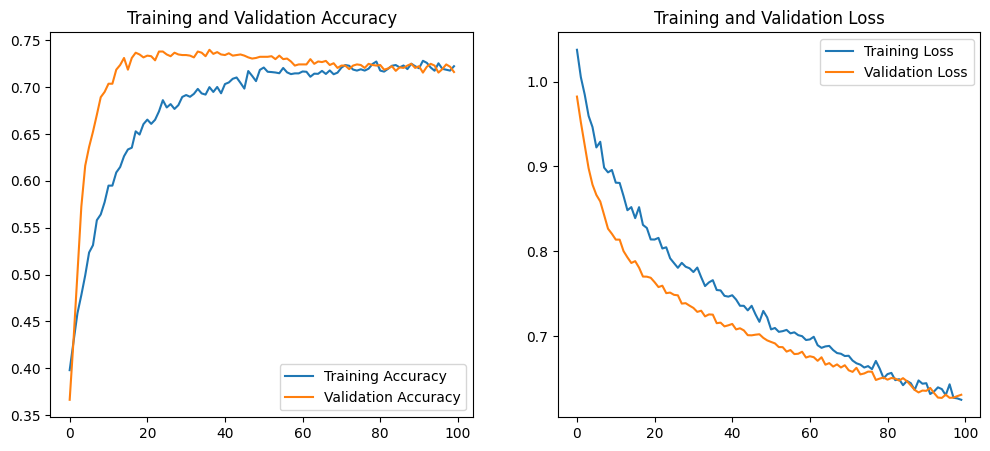

In [6]:
# Trực quan hóa quá trình học
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


--- Bước 5: Đánh giá mô hình tốt nhất trên tập Test ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Ngưỡng xác suất tối ưu tìm được: 0.6092

Báo cáo Phân loại với Ngưỡng Tối ưu:
              precision    recall  f1-score   support

    Stay (0)       0.89      0.84      0.86      1609
   Leave (1)       0.46      0.56      0.51       391

    accuracy                           0.79      2000
   macro avg       0.67      0.70      0.68      2000
weighted avg       0.80      0.79      0.79      2000



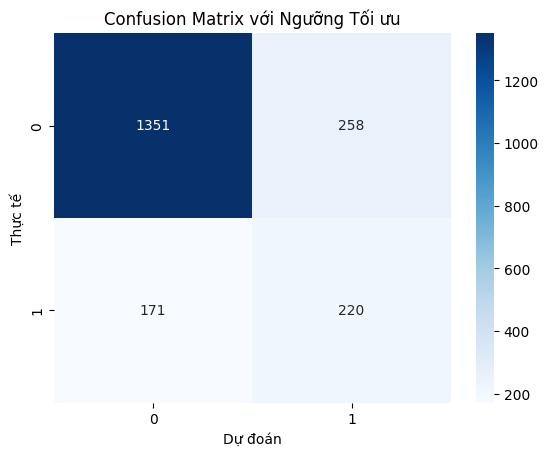

In [7]:
# --- Bước 5: Đánh giá Mô hình Tốt nhất ---
print("\n--- Bước 5: Đánh giá mô hình tốt nhất trên tập Test ---")
# Tải lại mô hình tốt nhất đã được lưu
best_model = tf.keras.models.load_model('best_model.keras')

# Đánh giá trên tập test
predictions_proba = best_model.predict(X_test_scaled)
# Tìm ngưỡng tối ưu thay vì dùng 0.5
precisions, recalls, thresholds = precision_recall_curve(y_test, predictions_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9) # Tránh chia cho 0
optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"Ngưỡng xác suất tối ưu tìm được: {optimal_threshold:.4f}")

predictions_optimal = (predictions_proba > optimal_threshold).astype(int)

print("\nBáo cáo Phân loại với Ngưỡng Tối ưu:")
print(classification_report(y_test, predictions_optimal, target_names=['Stay (0)', 'Leave (1)']))

# Trực quan hóa ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix với Ngưỡng Tối ưu')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

In [8]:
# --- Bước 7: Dự đoán trên một nhân viên cụ thể ---
print("\n--- Bước 7: Ví dụ dự đoán trên một nhân viên mới ---")

# Lấy một mẫu từ tập test để làm ví dụ
sample_employee_scaled = X_test_scaled[0].reshape(1, -1)
sample_employee_original = df.loc[X_test.index[0]]
sample_department = Department.loc[X_test.index[0]]  # Sử dụng biến Department đã lưu

prediction_single = model.predict(sample_employee_scaled)

print(f"Thông tin nhân viên:")
print(f"Department: {sample_department}")
print(f"MonthlyIncome: {sample_employee_original['MonthlyIncome']}")
print(f"JobSatisfaction: {sample_employee_original['JobSatisfaction']}")
print(f"\nXác suất nghỉ việc được dự đoán: {prediction_single[0][0]*100:.2f}%")

if prediction_single[0][0] > 0.5:
    print("Kết luận: Nhân viên này có RỦI RO NGHỈ VIỆC CAO. HR nên có biện pháp can thiệp.")
else:
    print("Kết luận: Nhân viên này có rủi ro nghỉ việc thấp.")


--- Bước 7: Ví dụ dự đoán trên một nhân viên mới ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Thông tin nhân viên:
Department: Khối Marketing
MonthlyIncome: 35304000
JobSatisfaction: 3

Xác suất nghỉ việc được dự đoán: 39.17%
Kết luận: Nhân viên này có rủi ro nghỉ việc thấp.


# Phân cụm AutoEncoding + Kmeans và phân lớp trên từng cụm


In [9]:
print("=== HYBRID PIPELINE: AUTOENCODER + KMEANS + PHÂN LỚP TRÊN TỪNG CỤM ===")

# 1. Đọc và chuẩn bị dữ liệu
print("\n=== BƯỚC 1: CHUẨN BỊ DỮ LIỆU ===")
df = pd.read_csv('ngan_hang_hr_data (2).csv')

# Tiền xử lý dữ liệu
drop_cols = ['EmployeeID', 'FullName']
df = df.drop(columns=drop_cols)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = df[(df['MonthlyIncome'] >= 0) & (df['PercentSalaryHike'] >= 0)]
Department = df['Department'].copy()
# Encode các biến phân loại
cat_cols = ['Gender', 'LocationType', 'LocationName', 'JobRole', 'OverTime', 'Department']
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print(f"Tỷ lệ Attrition: {df['Attrition'].value_counts(normalize=True)}")   

=== HYBRID PIPELINE: AUTOENCODER + KMEANS + PHÂN LỚP TRÊN TỪNG CỤM ===

=== BƯỚC 1: CHUẨN BỊ DỮ LIỆU ===
Tỷ lệ Attrition: Attrition
0    0.80458
1    0.19542
Name: proportion, dtype: float64


In [10]:
print("\n=== BƯỚC 2: CHUẨN BỊ FEATURES CHO CLUSTERING ===")
feature_cols = []
ordinal_features = ['JobSatisfaction', 'PerformanceRating', 'JobLevel', 'Education']
for c in df.columns:
    if df[c].dtype in [np.float64, np.int64] and (len(df[c].unique()) > 8 or c in ordinal_features):
        feature_cols.append(c)

for c in df.columns:
    if df[c].dtype == 'object' or df[c].dtype.name == 'category':
        if c not in feature_cols:
            le = LabelEncoder()
            df[c] = le.fit_transform(df[c].astype(str))
            feature_cols.append(c)

X_cluster = df[feature_cols].fillna(0).values
scaler_cluster = StandardScaler()
X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)

print(f"Features cho clustering: {len(feature_cols)}")
print(f"Samples: {X_scaled_cluster.shape[0]}")
print("Danh sách các feature dùng để cluster:")
for idx, col in enumerate(feature_cols, 1):
    print(f"{idx}. {col}")



=== BƯỚC 2: CHUẨN BỊ FEATURES CHO CLUSTERING ===
Features cho clustering: 9
Samples: 9999
Danh sách các feature dùng để cluster:
1. Age
2. JobLevel
3. YearsAtCompany
4. YearsSinceLastPromotion
5. KPI_Achievement_Pct
6. PerformanceRating
7. MonthlyIncome
8. PercentSalaryHike
9. JobSatisfaction


In [11]:
# 3. Autoencoder cho clustering
print("\n=== BƯỚC 3: AUTOENCODER CHO CLUSTERING ===")
class ClusteringAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    def encode(self, x):
        return self.encoder(x)

input_dim = X_scaled_cluster.shape[1]
latent_dim = 3
autoencoder = ClusteringAutoencoder(input_dim, latent_dim)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

X_tensor = torch.tensor(X_scaled_cluster, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 50
for epoch in range(n_epochs):
    autoencoder.train()
    epoch_loss = 0
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat = autoencoder(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss/len(X_scaled_cluster):.4f}")



=== BƯỚC 3: AUTOENCODER CHO CLUSTERING ===
Epoch 10/50 - Loss: 0.3133
Epoch 20/50 - Loss: 0.2960
Epoch 30/50 - Loss: 0.2881
Epoch 40/50 - Loss: 0.2820
Epoch 50/50 - Loss: 0.2779



=== BƯỚC 4: KMEANS CLUSTERING ===


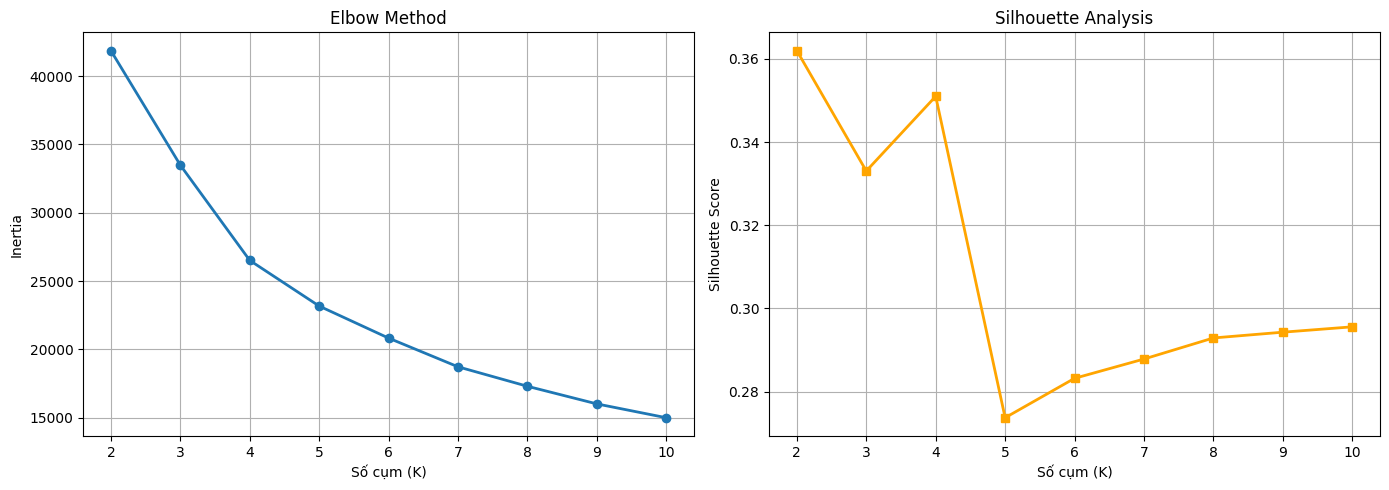

Số cụm tối ưu được chọn (bỏ qua k=2): 4


In [12]:
print("\n=== BƯỚC 4: KMEANS CLUSTERING ===")
autoencoder.eval()
with torch.no_grad():
    latent_vec = autoencoder.encode(X_tensor).numpy()

K_range = range(2, 11)  # Dải từ 2 đến 10, bạn có thể đổi tuỳ ý
inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(latent_vec)
    inertia.append(kmeans.inertia_)
    # Silhouette không tính với k=1, luôn >=2
    silhouette_scores.append(silhouette_score(latent_vec, labels))

# Vẽ Elbow và Silhouette trước khi chọn số cụm tốt nhất
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(list(K_range), inertia, marker='o', linewidth=2)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Số cụm (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

ax2.plot(list(K_range), silhouette_scores, marker='s', linewidth=2, color='orange')
ax2.set_title('Silhouette Analysis')
ax2.set_xlabel('Số cụm (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Chọn số cụm tối ưu nhưng KHÔNG chọn k=2 dù silhouette cao nhất ở đó
best_k_idx = np.argmax(silhouette_scores[1:]) + 1  # Bỏ index 0 ứng với k=2
optimal_k = list(K_range)[best_k_idx]
print(f"Số cụm tối ưu được chọn (bỏ qua k=2): {optimal_k}")

# Gán nhãn cluster cho toàn bộ dữ liệu
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_vec)
df['Cluster'] = cluster_labels

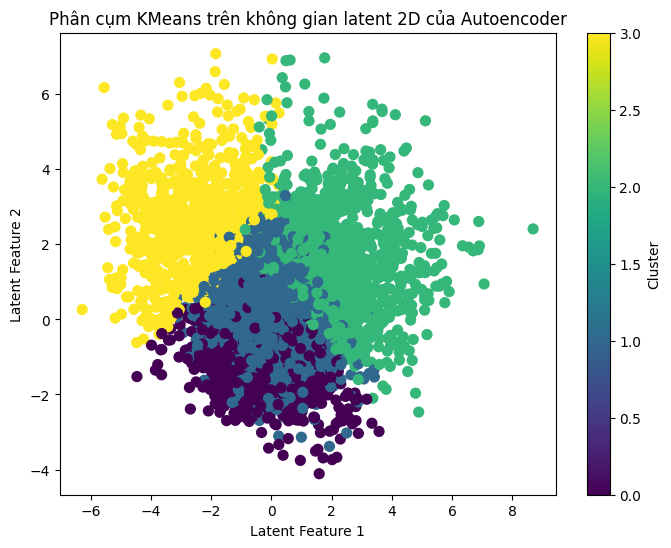

In [13]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_vec[:, 0], latent_vec[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("Phân cụm KMeans trên không gian latent 2D của Autoencoder")
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.colorbar(scatter, label="Cluster")
plt.show()



=== BƯỚC 5: PHÂN LỚP (MLP) RIÊNG TRÊN TỪNG CỤM ===

--- CLUSTER 0 ---
Accuracy trên cluster 0: 0.7280
Classification report:
              precision    recall  f1-score   support

           0     0.9084    0.7575    0.8261       301
           1     0.2843    0.5577    0.3766        52

    accuracy                         0.7280       353
   macro avg     0.5963    0.6576    0.6014       353
weighted avg     0.8164    0.7280    0.7599       353



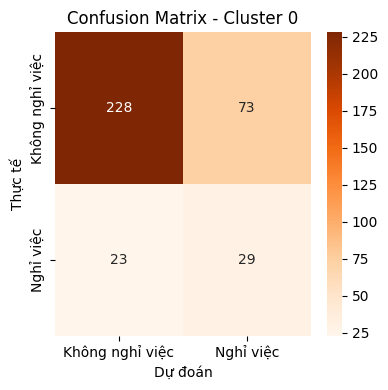


Top 10 feature importance cho cluster này:
                   Feature  Importance
8          JobSatisfaction    0.219677
5        PerformanceRating    0.175360
3  YearsSinceLastPromotion    0.175234
9                  Cluster    0.172443
4      KPI_Achievement_Pct    0.171377
0                      Age    0.170597
2           YearsAtCompany    0.169824
7        PercentSalaryHike    0.169467
6            MonthlyIncome    0.164500
1                 JobLevel    0.151407


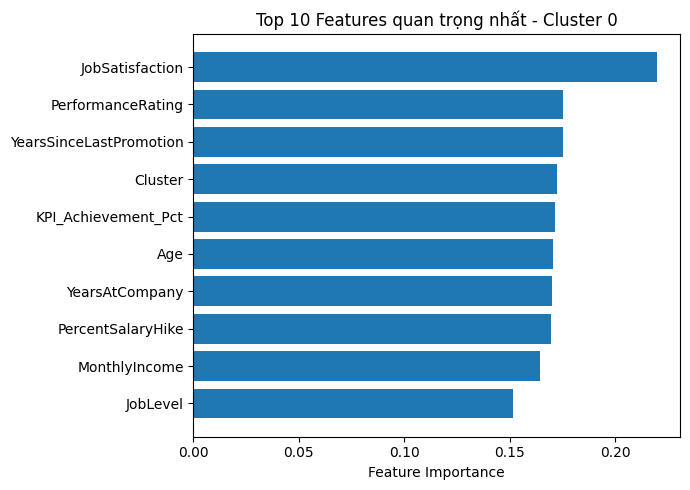


--- CLUSTER 1 ---
Accuracy trên cluster 1: 0.6829
Classification report:
              precision    recall  f1-score   support

           0     0.9106    0.6949    0.7883      1026
           1     0.2635    0.6154    0.3690       182

    accuracy                         0.6829      1208
   macro avg     0.5871    0.6552    0.5787      1208
weighted avg     0.8131    0.6829    0.7251      1208



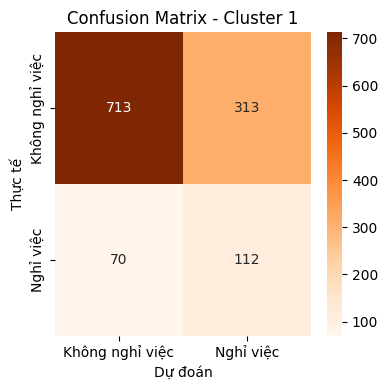


Top 10 feature importance cho cluster này:
                   Feature  Importance
8          JobSatisfaction    0.230366
6            MonthlyIncome    0.220307
4      KPI_Achievement_Pct    0.206616
9                  Cluster    0.187990
5        PerformanceRating    0.179893
1                 JobLevel    0.177871
3  YearsSinceLastPromotion    0.165776
0                      Age    0.160153
2           YearsAtCompany    0.155949
7        PercentSalaryHike    0.154008


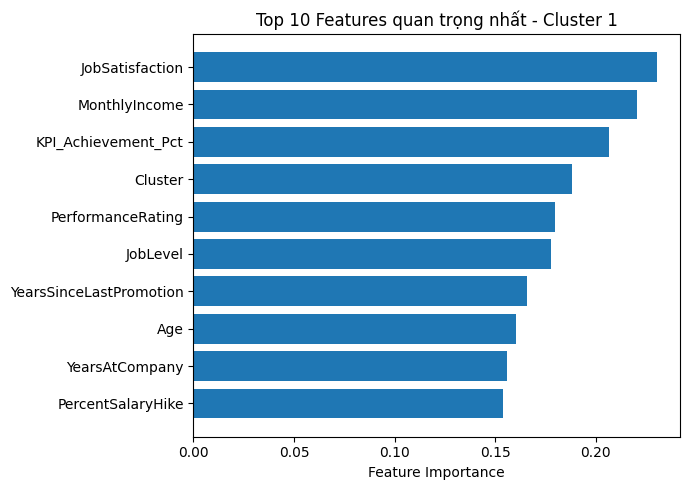


--- CLUSTER 2 ---
Accuracy trên cluster 2: 0.6882
Classification report:
              precision    recall  f1-score   support

           0     0.6884    0.6835    0.6859       139
           1     0.6879    0.6929    0.6904       140

    accuracy                         0.6882       279
   macro avg     0.6882    0.6882    0.6882       279
weighted avg     0.6882    0.6882    0.6882       279



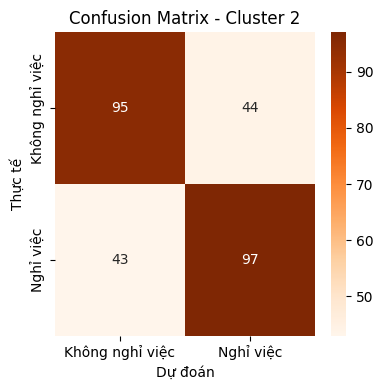


Top 10 feature importance cho cluster này:
                   Feature  Importance
8          JobSatisfaction    0.174924
3  YearsSinceLastPromotion    0.170262
5        PerformanceRating    0.168175
0                      Age    0.167351
4      KPI_Achievement_Pct    0.161170
9                  Cluster    0.156961
6            MonthlyIncome    0.155751
7        PercentSalaryHike    0.153426
1                 JobLevel    0.150798
2           YearsAtCompany    0.147164


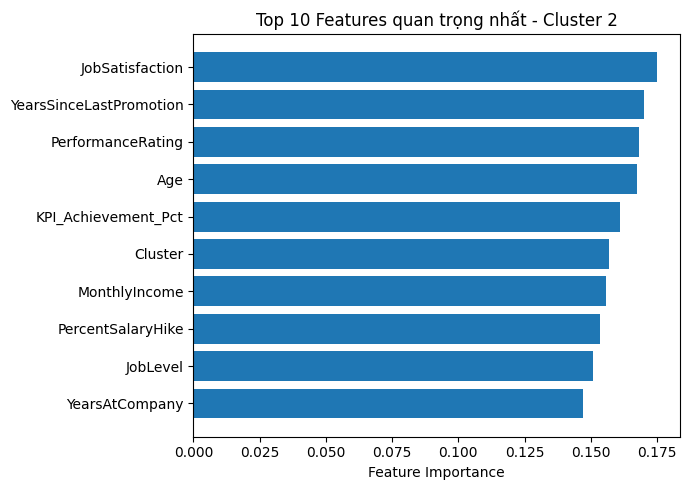


--- CLUSTER 3 ---
Accuracy trên cluster 3: 0.7840
Classification report:
              precision    recall  f1-score   support

           0     0.9225    0.8264    0.8718       144
           1     0.2424    0.4444    0.3137        18

    accuracy                         0.7840       162
   macro avg     0.5825    0.6354    0.5928       162
weighted avg     0.8469    0.7840    0.8098       162



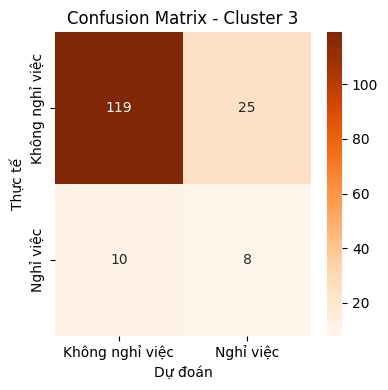


Top 10 feature importance cho cluster này:
                   Feature  Importance
0                      Age    0.245656
3  YearsSinceLastPromotion    0.222555
8          JobSatisfaction    0.183116
6            MonthlyIncome    0.176386
2           YearsAtCompany    0.159671
1                 JobLevel    0.153841
5        PerformanceRating    0.151896
4      KPI_Achievement_Pct    0.145775
9                  Cluster    0.138043
7        PercentSalaryHike    0.130393


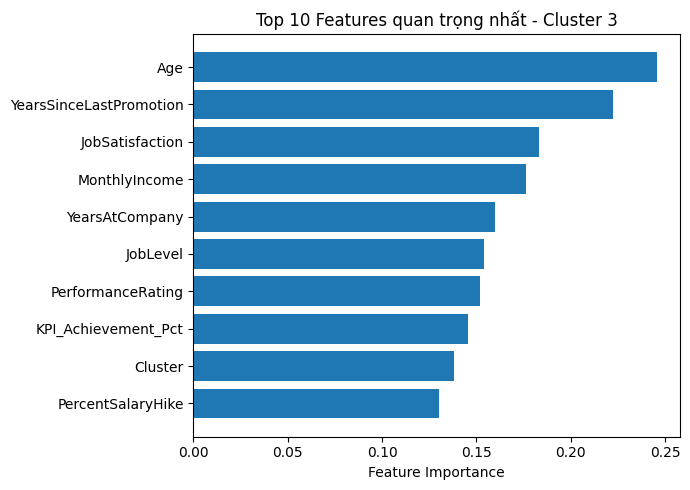

In [14]:
print("\n=== BƯỚC 5: PHÂN LỚP (MLP) RIÊNG TRÊN TỪNG CỤM ===")
classification_features = feature_cols + ['Cluster']
X_class = df[classification_features].values
y_class = df['Attrition'].values
scaler_class = StandardScaler()
X_scaled_class = scaler_class.fit_transform(X_class)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

for i in range(optimal_k):
    print(f"\n--- CLUSTER {i} ---")
    cluster_idx = df['Cluster'] == i
    X_c = X_scaled_class[cluster_idx]
    y_c = y_class[cluster_idx]
    # Bỏ qua cụm quá nhỏ hoặc chỉ có một class
    if len(np.unique(y_c)) < 2 or len(y_c) < 50:
        print("Cluster này quá nhỏ hoặc chỉ có một class, bỏ qua...")
        continue
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
    )
    smote_c = SMOTE(random_state=42)
    X_train_c_bal, y_train_c_bal = smote_c.fit_resample(X_train_c, y_train_c)
    train_dataset_c = TensorDataset(
        torch.tensor(X_train_c_bal, dtype=torch.float32),
        torch.tensor(y_train_c_bal, dtype=torch.long)
    )
    test_dataset_c = TensorDataset(
        torch.tensor(X_test_c, dtype=torch.float32),
        torch.tensor(y_test_c, dtype=torch.long)
    )
    train_loader_c = DataLoader(train_dataset_c, batch_size=32, shuffle=True)
    test_loader_c = DataLoader(test_dataset_c, batch_size=32, shuffle=False)

    mlp_c = MLPClassifier(X_c.shape[1])
    optimizer_c = torch.optim.Adam(mlp_c.parameters(), lr=1e-3)
    criterion_c = nn.CrossEntropyLoss()

    # Train (30 epochs)
    for epoch in range(30):
        mlp_c.train()
        for batch_x, batch_y in train_loader_c:
            optimizer_c.zero_grad()
            outputs = mlp_c(batch_x)
            loss = criterion_c(outputs, batch_y)
            loss.backward()
            optimizer_c.step()

    # Đánh giá
    mlp_c.eval()
    preds_c = []
    labels_c = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader_c:
            outputs = mlp_c(batch_x)
            _, predicted = torch.max(outputs, 1)
            preds_c.extend(predicted.numpy())
            labels_c.extend(batch_y.numpy())
    acc_c = accuracy_score(labels_c, preds_c)
    print(f"Accuracy trên cluster {i}: {acc_c:.4f}")
    print("Classification report:")
    print(classification_report(labels_c, preds_c, digits=4))
    cm_c = confusion_matrix(labels_c, preds_c)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_c, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=['Không nghỉ việc', 'Nghỉ việc'],
                yticklabels=['Không nghỉ việc', 'Nghỉ việc'])
    plt.title(f'Confusion Matrix - Cluster {i}')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.tight_layout()
    plt.show()
    first_layer_weights = mlp_c.layers[0].weight.data.abs().mean(dim=0).numpy()
    feature_names = classification_features
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': first_layer_weights
    }).sort_values('Importance', ascending=False)
    print("\nTop 10 feature importance cho cluster này:")
    print(feature_imp_df.head(10))
    plt.figure(figsize=(7, 5))
    plt.barh(feature_imp_df['Feature'][:10][::-1], feature_imp_df['Importance'][:10][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Features quan trọng nhất - Cluster {i}')
    plt.tight_layout()
    plt.show()


=== PHÂN TÍCH CLUSTER & ATTRITION ===

Tỷ lệ Attrition theo Cluster:
         Tổng số  Số nghỉ việc  Tỷ lệ nghỉ việc
Cluster                                        
0           1761           257           0.1459
1           6037           912           0.1511
2           1391           696           0.5004
3            810            89           0.1099


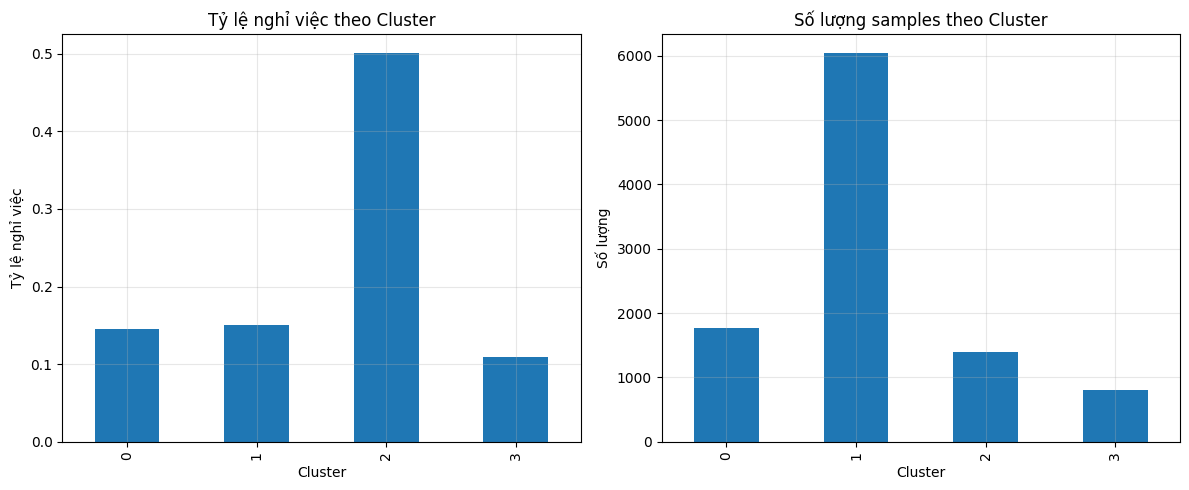

In [15]:
print("\n=== PHÂN TÍCH CLUSTER & ATTRITION ===")
cluster_attrition = df.groupby('Cluster')['Attrition'].agg(['count', 'sum', 'mean']).round(4)
cluster_attrition.columns = ['Tổng số', 'Số nghỉ việc', 'Tỷ lệ nghỉ việc']
print("\nTỷ lệ Attrition theo Cluster:")
print(cluster_attrition)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cluster_attrition['Tỷ lệ nghỉ việc'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Tỷ lệ nghỉ việc theo Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Tỷ lệ nghỉ việc')
axes[0].grid(True, alpha=0.3)

cluster_attrition['Tổng số'].plot(kind='bar', ax=axes[1])
axes[1].set_title('Số lượng samples theo Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Số lượng')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== TRUNG BÌNH CÁC FEATURE CHO MỖI CLUSTER ===
           Age  JobLevel  YearsAtCompany  YearsSinceLastPromotion  \
Cluster                                                             
0        34.16      3.87            4.63                     1.64   
1        30.26      1.99            3.79                     1.60   
2        34.10      3.13            9.13                     6.60   
3        31.70      2.73            4.83                     2.27   

         KPI_Achievement_Pct  PerformanceRating  MonthlyIncome  \
Cluster                                                          
0                      98.47               3.33    66726337.31   
1                      98.81               3.38    22813611.40   
2                      97.23               3.25    45867217.83   
3                     121.29               4.63    40880758.02   

         PercentSalaryHike  JobSatisfaction  
Cluster                                      
0                    11.44             2.86  
1 

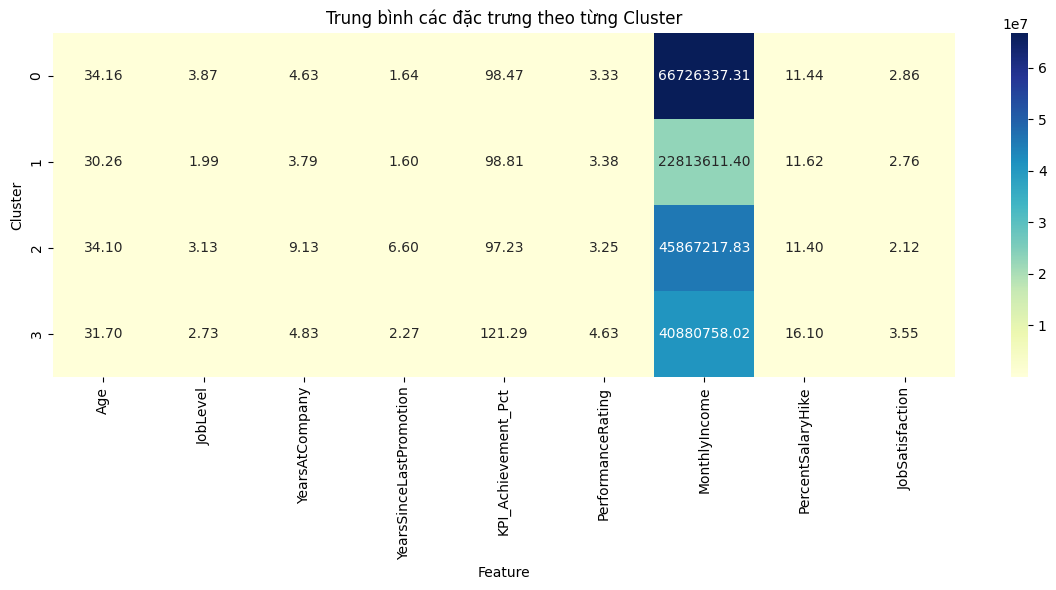

In [16]:
print("\n=== TRUNG BÌNH CÁC FEATURE CHO MỖI CLUSTER ===")
feature_cols_present = [col for col in feature_cols if col in df.columns]
mean_features_by_cluster = df.groupby('Cluster')[feature_cols_present].mean().round(2)
print(mean_features_by_cluster)
plt.figure(figsize=(12, 6))
sns.heatmap(mean_features_by_cluster, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title('Trung bình các đặc trưng theo từng Cluster')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

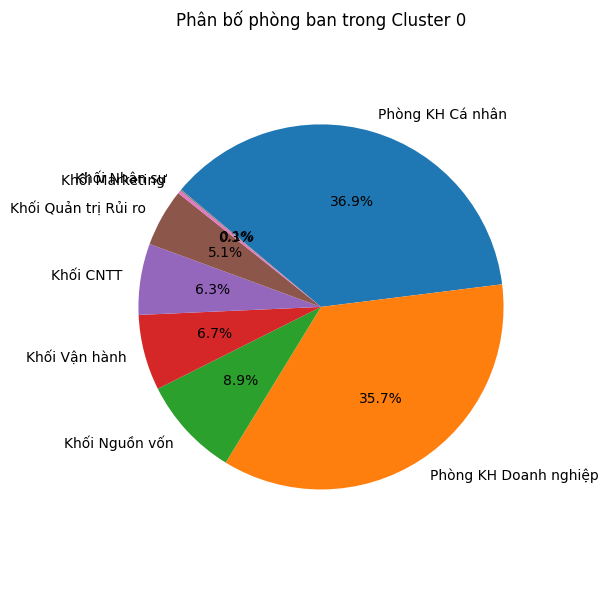


Cluster 0 - Phân bố phòng ban (%):
Department
Phòng KH Cá nhân         36.91
Phòng KH Doanh nghiệp    35.72
Khối Nguồn vốn            8.86
Khối Vận hành             6.70
Khối CNTT                 6.30
Khối Quản trị Rủi ro      5.11
Khối Marketing            0.28
Khối Nhân sự              0.11
Name: count, dtype: float64


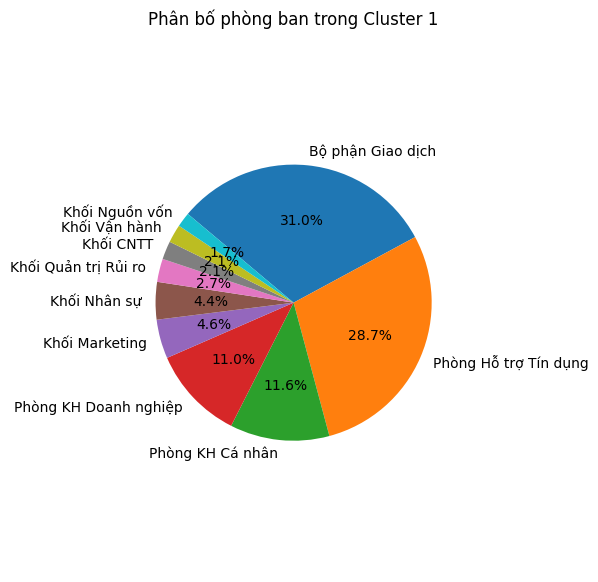


Cluster 1 - Phân bố phòng ban (%):
Department
Bộ phận Giao dịch        31.01
Phòng Hỗ trợ Tín dụng    28.71
Phòng KH Cá nhân         11.64
Phòng KH Doanh nghiệp    10.98
Khối Marketing            4.57
Khối Nhân sự              4.39
Khối Quản trị Rủi ro      2.72
Khối CNTT                 2.14
Khối Vận hành             2.14
Khối Nguồn vốn            1.71
Name: count, dtype: float64


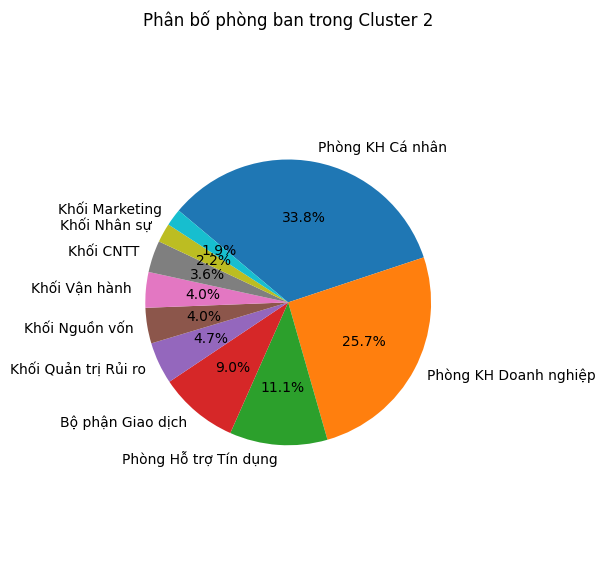


Cluster 2 - Phân bố phòng ban (%):
Department
Phòng KH Cá nhân         33.79
Phòng KH Doanh nghiệp    25.66
Phòng Hỗ trợ Tín dụng    11.07
Bộ phận Giao dịch         8.99
Khối Quản trị Rủi ro      4.74
Khối Nguồn vốn            4.03
Khối Vận hành             4.03
Khối CNTT                 3.59
Khối Nhân sự              2.16
Khối Marketing            1.94
Name: count, dtype: float64


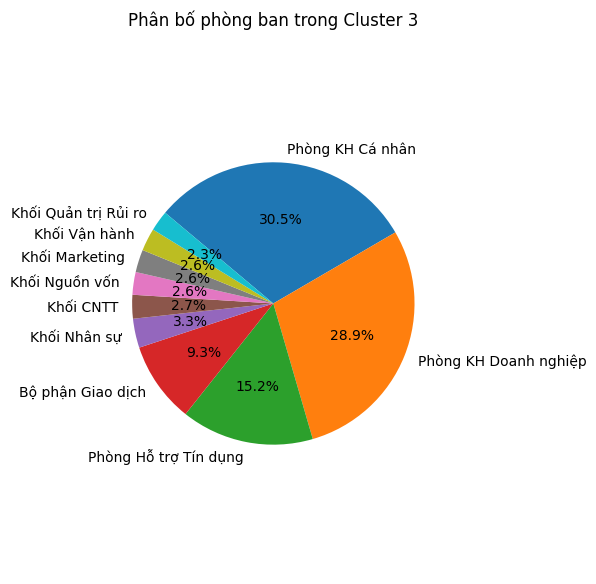


Cluster 3 - Phân bố phòng ban (%):
Department
Phòng KH Cá nhân         30.49
Phòng KH Doanh nghiệp    28.89
Phòng Hỗ trợ Tín dụng    15.19
Bộ phận Giao dịch         9.26
Khối Nhân sự              3.33
Khối CNTT                 2.72
Khối Nguồn vốn            2.59
Khối Marketing            2.59
Khối Vận hành             2.59
Khối Quản trị Rủi ro      2.35
Name: count, dtype: float64


In [17]:
clusters = sorted(df['Cluster'].unique())
n_clusters = len(clusters)

for c in clusters:
    idx = df['Cluster'] == c
    dept_counts = Department[idx].value_counts()
    dept_percents = dept_counts / dept_counts.sum() * 100

    plt.figure(figsize=(6, 6))
    plt.pie(dept_percents, labels=dept_percents.index, autopct='%1.1f%%', startangle=140, counterclock=False)
    plt.title(f'Phân bố phòng ban trong Cluster {c}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # In thêm bảng phân bổ %
    print(f"\nCluster {c} - Phân bố phòng ban (%):")
    print(dept_percents.round(2))
